<a href="https://colab.research.google.com/github/ckj18/ToBigs_workspace/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 19기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
<!-- ![image.png](attachment:image.png) -->

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [ ]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 

## 데이터 불러오기

In [ ]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [ ]:
# 데이터 확인 -> 결측값 없음, type: float 
samsung_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


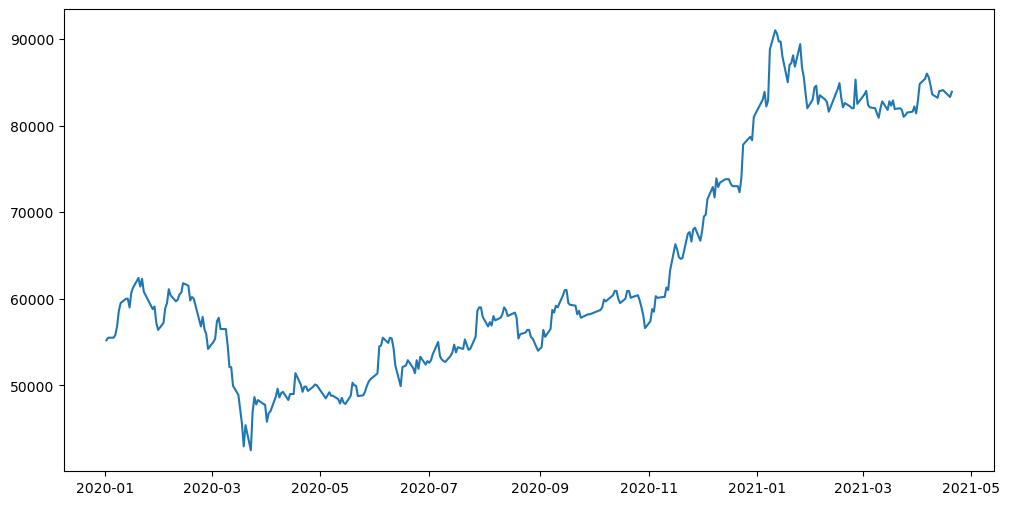

In [ ]:
# 데이터 시각화(일별 주가 변동 그래프) 
plt.figure(figsize=(12,6))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel=('Day')
plt.ylabel=('Price')
plt.show()


    1. 전체 그래프를 봤을 때 계절성이나 주기성이 보이지 않음
    2. 비정상 시계열
    3. 정상성을 만족하지 않은 경향이므로 차분이 필요

In [ ]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(samsung_df, test_size=0.3, shuffle=False)

C:\Users\chlru\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


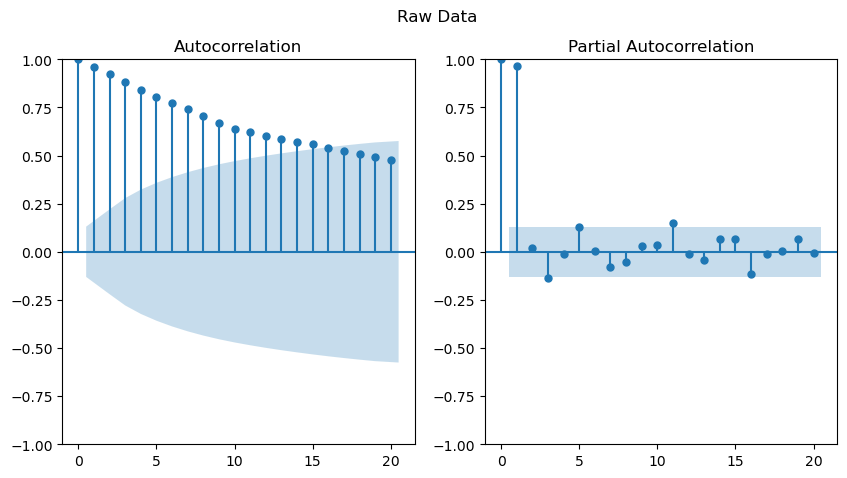

In [ ]:
# ACF, PACF 이용 
import statsmodels.api as sm

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['price'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['price'].values.squeeze(), lags=20, ax=ax[1])
plt.show()

In [ ]:
# 차분이 필요한지 확인
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [ ]:
# 차분화된 데이터
train_diff = train_data.copy()
train_diff = train_diff['price'].diff() # 차분
train_diff = train_diff.dropna()

C:\Users\chlru\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


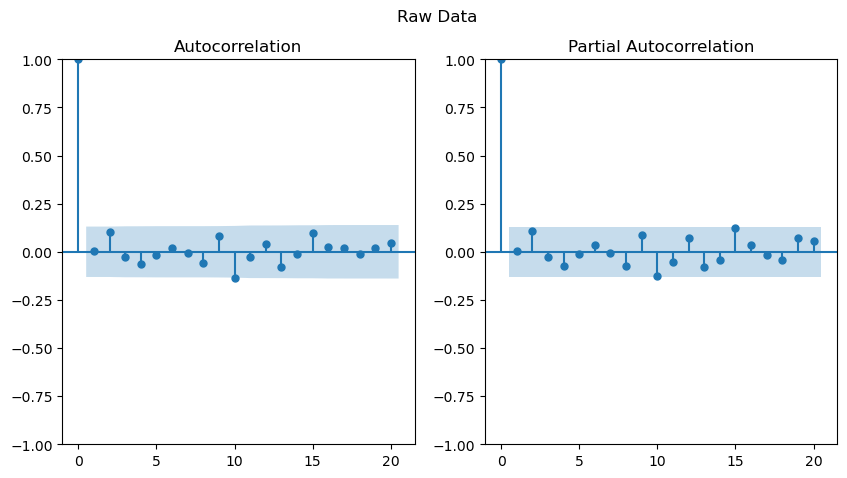

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_diff.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_diff.values.squeeze(), lags=20, ax=ax[1])
plt.show()

In [ ]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = pm.auto_arima(y = train_data['price']        # 데이터
                      , d = n_diffs           # 차분 차수, ndiffs 결과
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1   
                      , seasonal = False # 계절성 X
                      , error_action='ignore'
                      , stepwise = False
                      , trace=True
                      )

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3786.147, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3788.126, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3789.677, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3791.641, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3788.102, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3790.088, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3791.493, Time=0.62 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3793.586, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3789.597, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3791.601, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3793.590, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3791.599, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3793.601, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec

Best model:  ARIMA(

##### ARIMA(0,1,0)을 최종모형으로 선택

In [ ]:
model.fit(train_data)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1891.073
Date:                Tue, 14 Mar 2023   AIC                           3786.147
Time:                        21:29:17   BIC                           3792.970
Sample:                             0   HQIC                          3788.901
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     57.1429     75.982      0.752      0.452     -91.779     206.065
sigma2       1.26e+06   9.81e+04     12.845      0.000    1.07e+06    1.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.67
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

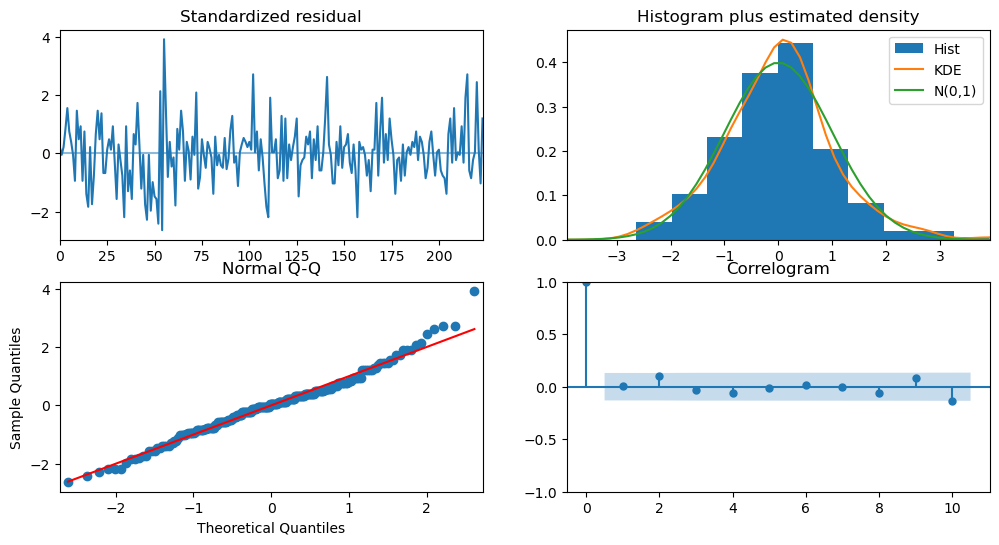

In [ ]:
# 모델 진단
model.plot_diagnostics(figsize=(12, 6))
plt.show()

#### 데이터 예측

C:\Users\chlru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


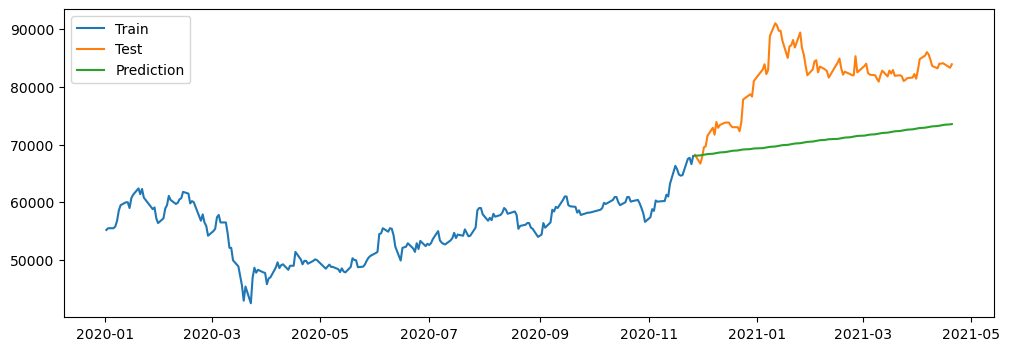

In [ ]:
# 테스트 데이터 개수만큼 예측
pred = model.predict(n_periods=len(test_data)) 
pred = pd.DataFrame(pred.values, index = test_data.index, columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_data, label='Train')        # 훈련 데이터
plt.plot(test_data, label='Test')          # 테스트 데이터
plt.plot(pred, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

### 예측이 잘 되지 않음

In [ ]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 
        , return_conf_int=True)              # 한 스탭씩 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [ ]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

# 한 스탭마다 모델 업데이트

for new_ob in test_data.values:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model.update(new_ob)

C:\Users\chlru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# 십의 자리수 반올림
y_pred = np.round(np.round(y_pred) / 100) * 100

In [ ]:
pd.DataFrame({"test": test_data['price'].values, "pred": y_pred})

,test,pred
0,68200.0,68100.0
1,66700.0,68300.0
2,67800.0,66800.0
3,69500.0,67900.0
4,69700.0,69600.0
...,...,...
92,84000.0,84100.0
93,84100.0,84100.0
94,83900.0,84200.0
95,83300.0,84000.0


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  322
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2736.895
Date:                Tue, 14 Mar 2023   AIC                           5477.791
Time:                        21:29:40   BIC                           5485.334
Sample:                             0   HQIC                          5480.803
                                - 322                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.4302     70.857      1.262      0.207     -49.447     228.308
sigma2       1.49e+06   8.81e+04     16.906      0.000    1.32e+06    1.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                61.49
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.54
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

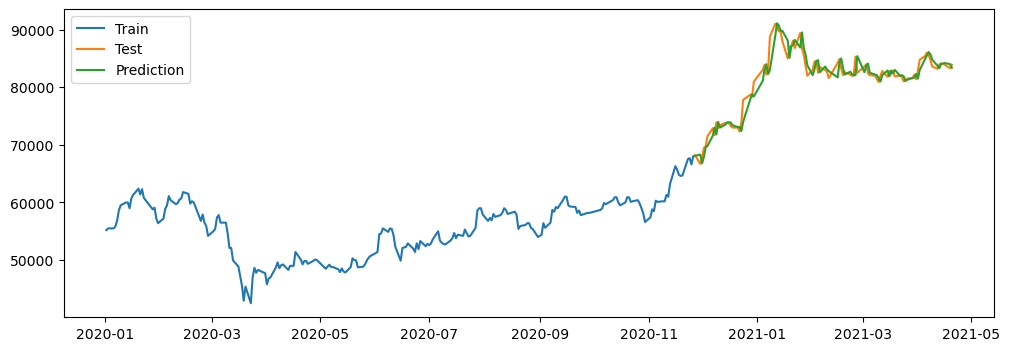

In [ ]:
# 테스트 데이터 개수만큼 예측
pred = pd.DataFrame(y_pred, index = test_data.index, columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_data, label='Train')        # 훈련 데이터
plt.plot(test_data, label='Test')          # 테스트 데이터
plt.plot(pred, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()